# Neural network classification with Pytorch

Book version of this notebook: https://www.learnpytorch.io/02_pytorch_classification/

## 1. Make classification data and get it ready

In [108]:

from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np
import requests
from pathlib import Path

In [109]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)


In [110]:
len(X), len(y)

(1000, 1000)

In [111]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [112]:
# Make dataframe of circle data
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
print(circles)

           X1        X2  label
0    0.754246  0.231481      1
1   -0.756159  0.153259      1
2   -0.815392  0.173282      1
3   -0.393731  0.692883      1
4    0.442208 -0.896723      0
..        ...       ...    ...
995  0.244054  0.944125      0
996 -0.978655 -0.272373      0
997 -0.136900 -0.810012      1
998  0.670362 -0.767502      0
999  0.281057  0.963824      0

[1000 rows x 3 columns]


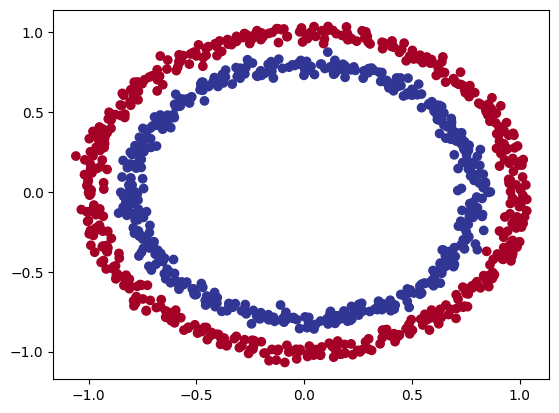

In [113]:
# Visualize, visualize, visualize
plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

Note : The data we are working with is often refered to a toy dataset, 
a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [114]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train/test splits


In [115]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # convert from float64 to float32 tensor
y = torch.from_numpy(y).type(torch.float) 

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [116]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [117]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [118]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build the model

To do so, we want to:
1. Setup device agonistic code so  our code will onto the GPU
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training loop and a test loop

In [119]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Let's create a model that:

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data.
3. Define a forward method that returns the output of the forward pass (or forward computation) of the model.
4. Instentiate an instance of our model class and send it to the target `device`.

In [120]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=8)
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=8),
        #     nn.Linear(in_features=8, out_features=1)
        # )
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x): # <- define the forward pass
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)

In [121]:
# 4. Create an instance of the model and send it to the target device
model_0 = CircleModelV0().to(device)
print(model_0)

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)


In [122]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [123]:
# Let's replicate the model above using nn.Sequential()
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=8),
#     nn.Linear(in_features=8, out_features=1)
# ).to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [124]:
model_0.state_dict() # number of weights fit the number of branchs and the number of biais fit the number of neurons

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                     device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]],
                     device='cuda:0')),
             ('layer_2.bias', tensor([0.2730], device='cuda:0'))])

In [125]:
# Make predictions with model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Set up the loss function and optimizer

Which loss function or optimizer should we use for our model?
    
For regression you might want MAE or MSE
For classification you might want Binary Cross Entropy or Categorical Cross Entropy

And for optimization you might want Adam or SGD, however Pytorch has many built-in functions.
    
* For common choices of losses functions and optimizers: https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer    
* For the loss function we use `torch.nn.BCEWithLogitsLoss`, for more on what binary cross entropy is check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition of what a logit is check out this article: https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow
* For different optimizers see: https://pytorch.org/docs/stable/optim.html

In [126]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires to have gone through the sigmoid activation function in the model first
# nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function + BCE
optimizer = torch.optim.SGD(params=model_0.parameters(),
                             lr=0.1)

In [127]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. Train the model

To train the model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. optimizer zero grad
4. loss backward (backpropagation)
5. optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> predictions labels

Our model outputs are going to be raw **logits**. 
We need to turn these **logits** into **prediction probabilities** by applying the activation function (sigmoid for binary classification and softmax for multiclass classification).

Then we need to turn these **prediction probabilities** into **predictions labels** by either rounding them or getting the index with the maximum value (`torch.argmax()`).

In [128]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
print(f"Logits: {y_logits}")

Logits: tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967]], device='cuda:0')


In [129]:
# Use the sigmoid activation function to get the prediction probabilities 
y_pred_probs = torch.sigmoid(y_logits)
print(f"Pred probs: {y_pred_probs}")

Pred probs: tensor([[0.4230],
        [0.3825],
        [0.5294],
        [0.3937],
        [0.5242]], device='cuda:0')


For our prediction probability values, we need to perform a range-style rounding on them:
* `y_preds_probs` >= 0.5, `y =1` (class 1)
* `y_preds_probs` < 0.5, `y =0` (class 0)

In [130]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop


In [131]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### TRAINING
    model_0.train() # train mode is on by default after construction

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy

    loss = loss_fn(y_logits,
                    y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                       y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### TESTING
    model_0.eval() # put the model in evaluation mode
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Caculate loss and accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70544, Accuracy: 48.25% | Test loss: 0.69447, Test acc: 53.00%
Epoch: 10 | Loss: 0.70088, Accuracy: 48.62% | Test loss: 0.69174, Test acc: 53.00%
Epoch: 20 | Loss: 0.69847, Accuracy: 48.38% | Test loss: 0.69083, Test acc: 54.50%
Epoch: 30 | Loss: 0.69698, Accuracy: 48.75% | Test loss: 0.69060, Test acc: 54.00%
Epoch: 40 | Loss: 0.69595, Accuracy: 49.00% | Test loss: 0.69066, Test acc: 54.00%
Epoch: 50 | Loss: 0.69521, Accuracy: 49.00% | Test loss: 0.69084, Test acc: 54.50%
Epoch: 60 | Loss: 0.69467, Accuracy: 49.00% | Test loss: 0.69109, Test acc: 53.00%
Epoch: 70 | Loss: 0.69425, Accuracy: 49.25% | Test loss: 0.69136, Test acc: 53.50%
Epoch: 80 | Loss: 0.69394, Accuracy: 49.25% | Test loss: 0.69165, Test acc: 54.00%
Epoch: 90 | Loss: 0.69371, Accuracy: 49.62% | Test loss: 0.69194, Test acc: 54.50%


## 4. Make predictions and evaluate the model
From the metrics, it look like the model is not learning anything.

So to inspect it let's make some predictions and make them visual!

In other words, visualize, visualize, visualize!

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/JoachimLombardi/Helper_functions/blob/master/course_ztm.py

In [132]:
# Download the helper function
if Path("course_ztm.py").is_file():
    print("course_ztm.py already exists, skipping download")
else:
    print("Downloading course_ztm.py")
    request = requests.get("https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [134]:
from helper_functions import plot_predictions, plot_decision_boundary

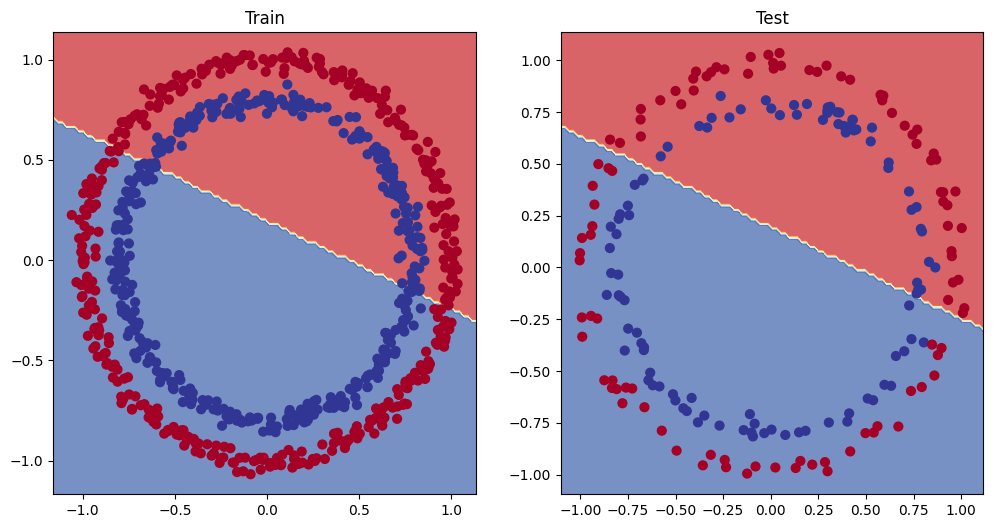

In [136]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)